In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy.fftpack import fft
import datetime as dt


Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


# Windowing


In [ ]:
labeled_field = pd.read_pickle("lpfiltered_labeled_field.pkl", compression="gzip")
labeled_field.head(), len(labeled_field), labeled_field.columns


(   user_id  ...                                               Time
 0       18  ...  [2018-12-01T22:50:30.450000000, 2018-12-01T22:...
 1       18  ...  [2018-12-01T23:29:55.700000000, 2018-12-01T23:...
 2       18  ...  [2018-12-01T23:46:33.650000000, 2018-12-01T23:...
 3       18  ...  [2018-12-01T23:58:27.250000000, 2018-12-01T23:...
 4        4  ...  [2018-12-02T10:27:37.000000000, 2018-12-02T10:...
 
 [5 rows x 8 columns],
 3186,
 Index(['user_id', 'activity_type_id', 'start', 'finish', 'X', 'Y', 'Z',
        'Time'],
       dtype='object'))

In [ ]:
bp = [0]  # breakpoints
added = 0
for i in range(len(labeled_field)):
    if (
        len(labeled_field.loc[i, "Time"]) < 600
    ):  # ignore windows with less than 600 samples
        continue
    bp.extend(
        [j for j in range(0, len(labeled_field.loc[i, "Time"]) - 300, 300)]
    )  # window at every 300 samples
    bp.append(len(labeled_field.loc[i, "Time"]))
    if len(bp) > 2: # if more than two windows found
        for k in range(1, len(bp)):
            newdf = pd.DataFrame(
                {
                    "user_id": [labeled_field.loc[i, "user_id"]],
                    "activity_type_id": [labeled_field.loc[i, "activity_type_id"]],
                    "start": [pd.to_datetime(labeled_field.loc[i, "Time"][bp[k - 1]])],
                    "finish": [pd.to_datetime(labeled_field.loc[i, "Time"][bp[k] - 1])],
                    "X": [labeled_field.loc[i, "X"][bp[k - 1] : bp[k]]],
                    "Y": [labeled_field.loc[i, "Y"][bp[k - 1] : bp[k]]],
                    "Z": [labeled_field.loc[i, "Z"][bp[k - 1] : bp[k]]],
                    "Time": [labeled_field.loc[i, "Time"][bp[k - 1] : bp[k]]],
                }
            )
            labeled_field = pd.concat([labeled_field, newdf], ignore_index=True)
        added += len(bp) - 2
        # print(f"index{i} dropped")
        labeled_field.drop(i)
    bp = [0]
print("Total", added, "row added")


In [ ]:
len(labeled_field)


25583

In [ ]:
labeled_field["length"] = labeled_field.Time.apply(len)
labeled_field = labeled_field[labeled_field["length"] > 40].reset_index(drop=True)
len(labeled_field)


24667

# Frequency and Time Domain Data


In [ ]:
fs = 20
fc = 0.1
bx, by, bz = [], [], []
for i in range(len(labeled_field)):
    b, a = signal.butter(3, fc / (fs / 2), "high")
    bx.append(signal.filtfilt(b, a, labeled_field.loc[i, "X"]))
    by.append(signal.filtfilt(b, a, labeled_field.loc[i, "Y"]))
    bz.append(signal.filtfilt(b, a, labeled_field.loc[i, "Z"]))
labeled_field["tbody-X"] = bx
labeled_field["tbody-Y"] = by
labeled_field["tbody-Z"] = bz
labeled_field.head()


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426..."
1,18,9,2018-12-01 23:29:35,2018-12-01 23:30:09,"[1.3620586299434982, 1.3607741168026488, 1.360...","[7.704226326846039, 7.753452679488208, 7.80137...","[0.09263532439116798, 0.7122787723283562, 1.31...","[2018-12-01T23:29:55.700000000, 2018-12-01T23:...",265,"[0.5632536892784036, 0.5684677740141921, 0.574...","[-0.08159910474086746, -0.042903023442574406, ...","[-0.24768816267381943, 0.281857205785375, 0.79..."
2,18,10,2018-12-01 23:46:32,2018-12-01 23:47:20,"[-4.22142105868042, -4.228173445447816, -4.232...","[4.633118408576495, 4.776392928058909, 4.92265...","[2.2883405806148702, 2.64521618074148, 2.98787...","[2018-12-01T23:46:33.650000000, 2018-12-01T23:...",921,"[-1.4511337674426725, -1.544740335749924, -1.6...","[-0.3931916964321358, -0.30305822582994857, -0...","[0.852093170180279, 1.208646684901996, 1.55152..."
3,18,9,2018-12-01 23:58:27,2018-12-01 23:59:03,"[0.011176190391082773, -0.12869343186136828, -...","[8.655850321930386, 8.76944554480367, 8.877926...","[3.977220032950275, 4.223088201691081, 4.45847...","[2018-12-01T23:58:27.250000000, 2018-12-01T23:...",670,"[-0.8935846554944386, -1.0630745771337158, -1....","[0.24593292531553584, 0.35636176794715324, 0.4...","[1.313201328819726, 1.591047226884147, 1.85886..."
4,4,5,2018-12-02 10:27:37,2018-12-02 10:28:22,"[0.10783071488709874, 0.3303105412467751, 0.54...","[7.093423475561911, 6.999542499158988, 6.90472...","[5.846058082782215, 5.935895343189449, 6.04110...","[2018-12-02T10:27:37.000000000, 2018-12-02T10:...",898,"[0.3949620293016062, 0.6160520050188684, 0.830...","[-0.8684353579027453, -0.9816469029986739, -1....","[1.6021970525231786, 1.7102600861222248, 1.834..."


In [ ]:
fs = 20
fc = 0.1
gx, gy, gz = [], [], []
for i in range(len(labeled_field)):
    b, a = signal.butter(3, fc / (fs / 2))
    gx.append(signal.filtfilt(b, a, labeled_field.loc[i, "X"]))
    gy.append(signal.filtfilt(b, a, labeled_field.loc[i, "Y"]))
    gz.append(signal.filtfilt(b, a, labeled_field.loc[i, "Z"]))
labeled_field["tgravity-X"] = gx
labeled_field["tgravity-Y"] = gy
labeled_field["tgravity-Z"] = gz
labeled_field.head()


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391..."
1,18,9,2018-12-01 23:29:35,2018-12-01 23:30:09,"[1.3620586299434982, 1.3607741168026488, 1.360...","[7.704226326846039, 7.753452679488208, 7.80137...","[0.09263532439116798, 0.7122787723283562, 1.31...","[2018-12-01T23:29:55.700000000, 2018-12-01T23:...",265,"[0.5632536892784036, 0.5684677740141921, 0.574...","[-0.08159910474086746, -0.042903023442574406, ...","[-0.24768816267381943, 0.281857205785375, 0.79...","[0.7778934049116013, 0.7713318303126115, 0.765...","[7.78447117081441, 7.795101874186796, 7.805659...","[0.2887873088211561, 0.3787048867387693, 0.468..."
2,18,10,2018-12-01 23:46:32,2018-12-01 23:47:20,"[-4.22142105868042, -4.228173445447816, -4.232...","[4.633118408576495, 4.776392928058909, 4.92265...","[2.2883405806148702, 2.64521618074148, 2.98787...","[2018-12-01T23:46:33.650000000, 2018-12-01T23:...",921,"[-1.4511337674426725, -1.544740335749924, -1.6...","[-0.3931916964321358, -0.30305822582994857, -0...","[0.852093170180279, 1.208646684901996, 1.55152...","[-2.7702880005982173, -2.683433788120924, -2.5...","[5.0263093823980185, 5.079450396493344, 5.1328...","[1.4362483617259316, 1.4365705105496596, 1.436..."
3,18,9,2018-12-01 23:58:27,2018-12-01 23:59:03,"[0.011176190391082773, -0.12869343186136828, -...","[8.655850321930386, 8.76944554480367, 8.877926...","[3.977220032950275, 4.223088201691081, 4.45847...","[2018-12-01T23:58:27.250000000, 2018-12-01T23:...",670,"[-0.8935846554944386, -1.0630745771337158, -1....","[0.24593292531553584, 0.35636176794715324, 0.4...","[1.313201328819726, 1.591047226884147, 1.85886...","[0.9048117930478055, 0.9344399275344912, 0.964...","[8.40997372186405, 8.413143563427502, 8.416295...","[2.6640102691552765, 2.6320312791862492, 2.599..."
4,4,5,2018-12-02 10:27:37,2018-12-02 10:28:22,"[0.10783071488709874, 0.3303105412467751, 0.54...","[7.093423475561911, 6.999542499158988, 6.90472...","[5.846058082782215, 5.935895343189449, 6.04110...","[2018-12-02T10:27:37.000000000, 2018-12-02T10:...",898,"[0.3949620293016062, 0.6160520050188684, 0.830...","[-0.8684353579027453, -0.9816469029986739, -1....","[1.6021970525231786, 1.7102600861222248, 1.834...","[-0.28713240328273776, -0.28574260928012857, -...","[7.96185908937324, 7.981189673227868, 8.000815...","[4.243861877413061, 4.225636133427083, 4.20690..."


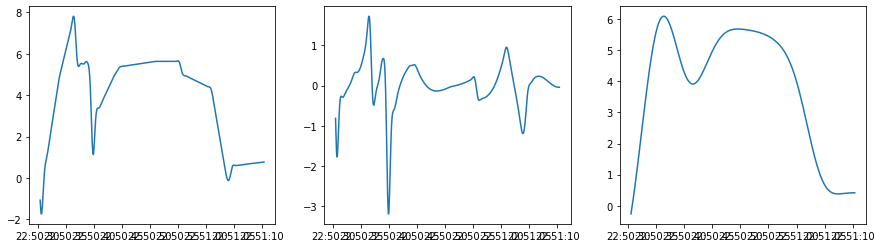

In [ ]:
example = 0
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(labeled_field.loc[example, "Time"], labeled_field.loc[example, "X"])
plt.subplot(1, 3, 2)
plt.plot(labeled_field.loc[example, "Time"], labeled_field.loc[example, "tbody-X"])
plt.subplot(1, 3, 3)
plt.plot(labeled_field.loc[example, "Time"], labeled_field.loc[example, "tgravity-X"])


In [ ]:
jerk_x = []
jerk_y = []
jerk_z = []
for i in range(len(labeled_field)):
    jerk_x.append(np.gradient(labeled_field.loc[i, "tbody-X"]))
    jerk_y.append(np.gradient(labeled_field.loc[i, "tbody-Y"]))
    jerk_z.append(np.gradient(labeled_field.loc[i, "tbody-Z"]))
labeled_field["tjerk-X"] = jerk_x
labeled_field["tjerk-Y"] = jerk_y
labeled_field["tjerk-Z"] = jerk_z
labeled_field.head()


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z,tjerk-X,tjerk-Y,tjerk-Z
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391...","[-0.2810703984996834, -0.2689010295990586, -0....","[0.03647605573681156, 0.03467790446724431, 0.0...","[0.036595681328448926, 0.03219534890377507, 0...."
1,18,9,2018-12-01 23:29:35,2018-12-01 23:30:09,"[1.3620586299434982, 1.3607741168026488, 1.360...","[7.704226326846039, 7.753452679488208, 7.80137...","[0.09263532439116798, 0.7122787723283562, 1.31...","[2018-12-01T23:29:55.700000000, 2018-12-01T23:...",265,"[0.5632536892784036, 0.5684677740141921, 0.574...","[-0.08159910474086746, -0.042903023442574406, ...","[-0.24768816267381943, 0.281857205785375, 0.79...","[0.7778934049116013, 0.7713318303126115, 0.765...","[7.78447117081441, 7.795101874186796, 7.805659...","[0.2887873088211561, 0.3787048867387693, 0.468...","[0.005214084735788549, 0.005642071164424223, 0...","[0.03869608129829305, 0.03808437403262374, 0.0...","[0.5295453684591944, 0.5229234324961214, 0.501..."
2,18,10,2018-12-01 23:46:32,2018-12-01 23:47:20,"[-4.22142105868042, -4.228173445447816, -4.232...","[4.633118408576495, 4.776392928058909, 4.92265...","[2.2883405806148702, 2.64521618074148, 2.98787...","[2018-12-01T23:46:33.650000000, 2018-12-01T23:...",921,"[-1.4511337674426725, -1.544740335749924, -1.6...","[-0.3931916964321358, -0.30305822582994857, -0...","[0.852093170180279, 1.208646684901996, 1.55152...","[-2.7702880005982173, -2.683433788120924, -2.5...","[5.0263093823980185, 5.079450396493344, 5.1328...","[1.4362483617259316, 1.4365705105496596, 1.436...","[-0.09360656830725156, -0.093277331654538, -0....","[0.09013347060218724, 0.09152193763555905, 0.0...","[0.3565535147217169, 0.3497154520714346, 0.329..."
3,18,9,2018-12-01 23:58:27,2018-12-01 23:59:03,"[0.011176190391082773, -0.12869343186136828, -...","[8.655850321930386, 8.76944554480367, 8.877926...","[3.977220032950275, 4.223088201691081, 4.45847...","[2018-12-01T23:58:27.250000000, 2018-12-01T23:...",670,"[-0.8935846554944386, -1.0630745771337158, -1....","[0.24593292531553584, 0.35636176794715324, 0.4...","[1.313201328819726, 1.591047226884147, 1.85886...","[0.9048117930478055, 0.9344399275344912, 0.964...","[8.40997372186405, 8.413143563427502, 8.416295...","[2.6640102691552765, 2.6320312791862492, 2.599...","[-0.16948992163927723, -0.16825374865386195, -...","[0.1104288426316174, 0.10788062044581434, 0.10...","[0.27784589806442095, 0.2728297573506345, 0.25..."
4,4,5,2018-12-02 10:27:37,2018-12-02 10:28:22,"[0.10783071488709874, 0.3303105412467751, 0.54...","[7.093423475561911, 6.999542499158988, 6.90472...","[5.846058082782215, 5.935895343189449, 6.04110...","[2018-12-02T10:27:37.000000000, 2018-12-02T10:...",898,"[0.3949620293016062, 0.6160520050188684, 0.830...","[-0.8684353579027453, -0.9816469029986739, -1....","[1.6021970525231786, 1.7102600861222248, 1.834...","[-0.28713240328273776, -0.28574260928012857, -...","[7.96185908937324, 7.981189673227868, 8.000815...","[4.243861877413061, 4.225636133427083, 4.20690...","[0.2210899757172622, 0.21791468498421446, 0.20...","[-0.11321154509592857, -0.11382725647849024, -...","[0.10806303359904623, 0.11600286064720233, 0.1..."


In [ ]:
labeled_field["fbody-X"] = labeled_field["tbody-X"].apply(lambda x: np.abs(fft(x)) ** 2)
labeled_field["fbody-Y"] = labeled_field["tbody-Y"].apply(lambda x: np.abs(fft(x)) ** 2)
labeled_field["fbody-Z"] = labeled_field["tbody-Z"].apply(lambda x: np.abs(fft(x)) ** 2)
labeled_field["fjerk-X"] = labeled_field["tjerk-X"].apply(lambda x: np.abs(fft(x)) ** 2)
labeled_field["fjerk-Y"] = labeled_field["tjerk-Y"].apply(lambda x: np.abs(fft(x)) ** 2)
labeled_field["fjerk-Z"] = labeled_field["tjerk-Z"].apply(lambda x: np.abs(fft(x)) ** 2)
labeled_field.head()


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z,tjerk-X,tjerk-Y,tjerk-Z,fbody-X,fbody-Y,fbody-Z,fjerk-X,fjerk-Y,fjerk-Z
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391...","[-0.2810703984996834, -0.2689010295990586, -0....","[0.03647605573681156, 0.03467790446724431, 0.0...","[0.036595681328448926, 0.03219534890377507, 0....","[7.27610871506813, 49.18947076110086, 677.4712...","[0.09936372653259903, 0.19729932546478854, 10....","[124.49488476388441, 151.7728584818144, 331.36...","[0.3973615131092107, 0.46510436312442643, 1.07...","[7.813362502028625e-05, 9.292966598611656e-05,...","[0.11830819029781056, 0.14155194005502342, 0.2..."
1,18,9,2018-12-01 23:29:35,2018-12-01 23:30:09,"[1.3620586299434982, 1.3607741168026488, 1.360...","[7.704226326846039, 7.753452679488208, 7.80137...","[0.09263532439116798, 0.7122787723283562, 1.31...","[2018-12-01T23:29:55.700000000, 2018-12-01T23:...",265,"[0.5632536892784036, 0.5684677740141921, 0.574...","[-0.08159910474086746, -0.042903023442574406, ...","[-0.24768816267381943, 0.281857205785375, 0.79...","[0.7778934049116013, 0.7713318303126115, 0.765...","[7.78447117081441, 7.795101874186796, 7.805659...","[0.2887873088211561, 0.3787048867387693, 0.468...","[0.005214084735788549, 0.005642071164424223, 0...","[0.03869608129829305, 0.03808437403262374, 0.0...","[0.5295453684591944, 0.5229234324961214, 0.501...","[315.62750134004926, 2267.728832655998, 24901....","[94.35544869489276, 171.6956882672789, 2255.77...","[8210.801178218766, 29915.070196564076, 26960....","[0.00034453922734404375, 1.3064450605453777, 5...","[0.3057238894525378, 0.42986708764424186, 7.86...","[0.06400000017615878, 15.775538727883704, 59.5..."
2,18,10,2018-12-01 23:46:32,2018-12-01 23:47:20,"[-4.22142105868042, -4.228173445447816, -4.232...","[4.633118408576495, 4.776392928058909, 4.92265...","[2.2883405806148702, 2.64521618074148, 2.98787...","[2018-12-01T23:46:33.650000000, 2018-12-01T23:...",921,"[-1.4511337674426725, -1.544740335749924, -1.6...","[-0.3931916964321358, -0.30305822582994857, -0...","[0.852093170180279, 1.208646684901996, 1.55152...","[-2.7702880005982173, -2.683433788120924, -2.5...","[5.0263093823980185, 5.079450396493344, 5.1328...","[1.4362483617259316, 1.4365705105496596, 1.436...","[-0.09360656830725156, -0.093277331654538, -0....","[0.09013347060218724, 0.09152193763555905, 0.0...","[0.3565535147217169, 0.3497154520714346, 0.329...","[9.920885086481746, 175.47281671956205, 1124.7...","[649.6040610803229, 749.091259827949, 1010.285...","[1116.571137363764, 1008.0966006598189, 1021.8...","[5.727987888556263, 6.094782594854818, 7.95897...","[1.5630497127679297, 1.6169478149010688, 1.898...","[2.1122262136038152, 2.2083265160617045, 2.244..."
3,18,9,2018-12-01 23:58:27,2018-12-01 23:59:03,"[0.011176190391082773, -0.12869343186136828, -...","[8.655850321930386, 8.76944554480367, 8.877926...","[3.977220032950275, 4.223088201691081, 4.45847...","[2018-12-01T23:58:27.250000000, 2018-12-01T23:...",670,"[-0.8935846554944386, -1.0630745771337158, -1....","[0.24593292531553584, 0.35636176794715324, 0.4...","[1.313201328819726, 1.591047226884147, 1.85886...","[0.9048117930478055, 0.9344399275344912, 0.964...","[8.40997372186405, 8.413143563427502, 8.416295...","[2.6640102691552765, 2.6320312791862492, 2.599...","[-0.16948992163927723, -0.16825374865386195, -...","[0.1104288426316174, 0.10788062044581434, 0.10...","[0.27784589806442095

In [ ]:
X = []
for i in range(len(labeled_field)):
    x = labeled_field.loc[i, "tbody-X"]
    y = labeled_field.loc[i, "tbody-Y"]
    z = labeled_field.loc[i, "tbody-Z"]
    a = np.vstack([x, y, z])
    X.append(np.linalg.norm(a, axis=0))
labeled_field["tbody_mag"] = X
labeled_field.head(1)


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z,tjerk-X,tjerk-Y,tjerk-Z,fbody-X,fbody-Y,fbody-Z,fjerk-X,fjerk-Y,fjerk-Z,tbody_mag
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391...","[-0.2810703984996834, -0.2689010295990586, -0....","[0.03647605573681156, 0.03467790446724431, 0.0...","[0.036595681328448926, 0.03219534890377507, 0....","[7.27610871506813, 49.18947076110086, 677.4712...","[0.09936372653259903, 0.19729932546478854, 10....","[124.49488476388441, 151.7728584818144, 331.36...","[0.3973615131092107, 0.46510436312442643, 1.07...","[7.813362502028625e-05, 9.292966598611656e-05,...","[0.11830819029781056, 0.14155194005502342, 0.2...","[0.8902421972636303, 1.16595774205342, 1.41954..."


In [ ]:
X = []
for i in range(len(labeled_field)):
    x = labeled_field.loc[i, "tgravity-X"]
    y = labeled_field.loc[i, "tgravity-Y"]
    z = labeled_field.loc[i, "tgravity-Z"]
    a = np.vstack([x, y, z])
    X.append(np.linalg.norm(a, axis=0))
labeled_field["tgravity_mag"] = X
labeled_field.head(1)


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z,tjerk-X,tjerk-Y,tjerk-Z,fbody-X,fbody-Y,fbody-Z,fjerk-X,fjerk-Y,fjerk-Z,tbody_mag,tgravity_mag
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391...","[-0.2810703984996834, -0.2689010295990586, -0....","[0.03647605573681156, 0.03467790446724431, 0.0...","[0.036595681328448926, 0.03219534890377507, 0....","[7.27610871506813, 49.18947076110086, 677.4712...","[0.09936372653259903, 0.19729932546478854, 10....","[124.49488476388441, 151.7728584818144, 331.36...","[0.3973615131092107, 0.46510436312442643, 1.07...","[7.813362502028625e-05, 9.292966598611656e-05,...","[0.11830819029781056, 0.14155194005502342, 0.2...","[0.8902421972636303, 1.16595774205342, 1.41954...","[7.859014638029434, 7.8430364142363835, 7.8275..."


In [ ]:
X = []
for i in range(len(labeled_field)):
    x = labeled_field.loc[i, "tjerk-X"]
    y = labeled_field.loc[i, "tjerk-Y"]
    z = labeled_field.loc[i, "tjerk-Z"]
    a = np.vstack([x, y, z])
    X.append(np.linalg.norm(a, axis=0))
labeled_field["tjerk_mag"] = X
labeled_field.head(1)


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z,tjerk-X,tjerk-Y,tjerk-Z,fbody-X,fbody-Y,fbody-Z,fjerk-X,fjerk-Y,fjerk-Z,tbody_mag,tgravity_mag,tjerk_mag
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391...","[-0.2810703984996834, -0.2689010295990586, -0....","[0.03647605573681156, 0.03467790446724431, 0.0...","[0.036595681328448926, 0.03219534890377507, 0....","[7.27610871506813, 49.18947076110086, 677.4712...","[0.09936372653259903, 0.19729932546478854, 10....","[124.49488476388441, 151.7728584818144, 331.36...","[0.3973615131092107, 0.46510436312442643, 1.07...","[7.813362502028625e-05, 9.292966598611656e-05,...","[0.11830819029781056, 0.14155194005502342, 0.2...","[0.8902421972636303, 1.16595774205342, 1.41954...","[7.859014638029434, 7.8430364142363835, 7.8275...","[0.2857801872887258, 0.27303271098663057, 0.23..."


In [ ]:
X = []
for i in range(len(labeled_field)):
    x = labeled_field.loc[i, "fjerk-X"]
    y = labeled_field.loc[i, "fjerk-Y"]
    z = labeled_field.loc[i, "fjerk-Z"]
    a = np.vstack([x, y, z])
    X.append(np.linalg.norm(a, axis=0))
labeled_field["fjerk_mag"] = X
labeled_field.head(1)


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z,tjerk-X,tjerk-Y,tjerk-Z,fbody-X,fbody-Y,fbody-Z,fjerk-X,fjerk-Y,fjerk-Z,tbody_mag,tgravity_mag,tjerk_mag,fjerk_mag
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391...","[-0.2810703984996834, -0.2689010295990586, -0....","[0.03647605573681156, 0.03467790446724431, 0.0...","[0.036595681328448926, 0.03219534890377507, 0....","[7.27610871506813, 49.18947076110086, 677.4712...","[0.09936372653259903, 0.19729932546478854, 10....","[124.49488476388441, 151.7728584818144, 331.36...","[0.3973615131092107, 0.46510436312442643, 1.07...","[7.813362502028625e-05, 9.292966598611656e-05,...","[0.11830819029781056, 0.14155194005502342, 0.2...","[0.8902421972636303, 1.16595774205342, 1.41954...","[7.859014638029434, 7.8430364142363835, 7.8275...","[0.2857801872887258, 0.27303271098663057, 0.23...","[0.414599814395578, 0.48616769634215934, 1.120..."


In [ ]:
X = []
for i in range(len(labeled_field)):
    x = labeled_field.loc[i, "fbody-X"]
    y = labeled_field.loc[i, "fbody-Y"]
    z = labeled_field.loc[i, "fbody-Z"]
    a = np.vstack([x, y, z])
    X.append(np.linalg.norm(a, axis=0))
labeled_field["fbody_mag"] = X
labeled_field.head(1)


,user_id,activity_type_id,start,finish,X,Y,Z,Time,length,tbody-X,tbody-Y,tbody-Z,tgravity-X,tgravity-Y,tgravity-Z,tjerk-X,tjerk-Y,tjerk-Z,fbody-X,fbody-Y,fbody-Z,fjerk-X,fjerk-Y,fjerk-Z,tbody_mag,tgravity_mag,tjerk_mag,fjerk_mag,fbody_mag
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,"[-1.0761912191930145, -1.2996604335255786, -1....","[7.278006110899289, 7.314203359813134, 7.34684...","[3.3749311576590486, 3.374820581767359, 3.3656...","[2018-12-01T22:50:30.450000000, 2018-12-01T22:...",800,"[-0.8129477328301933, -1.0940181313298767, -1....","[0.024235261513694217, 0.060711317250505784, 0...","[0.3620218302456193, 0.3986175115740682, 0.426...","[-0.2632424213578779, -0.20564125227277524, -0...","[7.253770878524064, 7.253492070703674, 7.25325...","[3.012909316629822, 2.9762030593762456, 2.9391...","[-0.2810703984996834, -0.2689010295990586, -0....","[0.03647605573681156, 0.03467790446724431, 0.0...","[0.036595681328448926, 0.03219534890377507, 0....","[7.27610871506813, 49.18947076110086, 677.4712...","[0.09936372653259903, 0.19729932546478854, 10....","[124.49488476388441, 151.7728584818144, 331.36...","[0.3973615131092107, 0.46510436312442643, 1.07...","[7.813362502028625e-05, 9.292966598611656e-05,...","[0.11830819029781056, 0.14155194005502342, 0.2...","[0.8902421972636303, 1.16595774205342, 1.41954...","[7.859014638029434, 7.8430364142363835, 7.8275...","[0.2857801872887258, 0.27303271098663057, 0.23...","[0.414599814395578, 0.48616769634215934, 1.120...","[124.7073693233744, 159.5451144113222, 754.235..."


In [ ]:
labeled_field.to_pickle("before_extraction_field.pkl", compression="gzip")


# Feature Extraction


In [ ]:
features = labeled_field.loc[
    :, ["user_id", "activity_type_id", "start", "finish", "length"]
].copy()


In [ ]:
features.head(1)


,user_id,activity_type_id,start,finish,length
0,18,9,2018-12-01 22:50:29,2018-12-01 22:51:16,800


In [ ]:
def entropy(a):
    a = (a - min(a)) / (max(a) - min(a))
    return stats.entropy(a)


## Common Features


In [ ]:
ft_name = "tbody"
print("0")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mean" + j] = labeled_field[ft_name + j].apply(np.mean)
print("1")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "std" + j] = labeled_field[ft_name + j].apply(np.std)
print("2")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "min" + j] = labeled_field[ft_name + j].apply(np.min)
print("3")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "max" + j] = labeled_field[ft_name + j].apply(np.max)
print("4")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "sum" + j] = labeled_field[ft_name + j].apply(np.sum)
print("5")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mad" + j] = labeled_field[ft_name + j].apply(
        lambda x: pd.Series(x).mad()
    )
print("6")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "energy" + j] = labeled_field[ft_name + j].apply(
        lambda x: sum(x**2) / len(x)
    )
print(7)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "entropy" + j] = labeled_field[ft_name + j].apply(entropy)
print(8)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "iqr" + j] = labeled_field[ft_name + j].apply(stats.iqr)
print(9)
x = labeled_field[ft_name + "-X"]
y = labeled_field[ft_name + "-Y"]
z = labeled_field[ft_name + "-Z"]
xyz = pd.concat([x, y, z], axis=1)
xyz[ft_name + "-X"] = xyz[ft_name + "-X"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Y"] = xyz[ft_name + "-Y"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Z"] = xyz[ft_name + "-Z"].apply(lambda x: x.sum() / len(x))
features[ft_name + "sma"] = xyz.sum(axis=1)
print(10)
cxy = []
cyz = []
czx = []
for i in range(len(x)):
    cxy.append(np.array(pd.Series(x[i]).corr(pd.Series(y[i]))))
    cyz.append(np.array(pd.Series(y[i]).corr(pd.Series(z[i]))))
    czx.append(np.array(pd.Series(z[i]).corr(pd.Series(x[i]))))
    # if not i % 1000:
    #     print(f"{i}.")
features[ft_name + "corr" + "-XY"] = cxy
features[ft_name + "corr" + "-YZ"] = cyz
features[ft_name + "corr" + "-ZX"] = czx


In [ ]:
ft_name = "tgravity"
print("0")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mean" + j] = labeled_field[ft_name + j].apply(np.mean)
print("1")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "std" + j] = labeled_field[ft_name + j].apply(np.std)
print("2")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "min" + j] = labeled_field[ft_name + j].apply(np.min)
print("3")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "max" + j] = labeled_field[ft_name + j].apply(np.max)
print("4")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "sum" + j] = labeled_field[ft_name + j].apply(np.sum)
print("5")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mad" + j] = labeled_field[ft_name + j].apply(
        lambda x: pd.Series(x).mad()
    )
print("6")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "energy" + j] = labeled_field[ft_name + j].apply(
        lambda x: sum(x**2) / len(x)
    )
print(7)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "entropy" + j] = labeled_field[ft_name + j].apply(entropy)
print(8)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "iqr" + j] = labeled_field[ft_name + j].apply(stats.iqr)
print(9)
x = labeled_field[ft_name + "-X"]
y = labeled_field[ft_name + "-Y"]
z = labeled_field[ft_name + "-Z"]
xyz = pd.concat([x, y, z], axis=1)
xyz[ft_name + "-X"] = xyz[ft_name + "-X"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Y"] = xyz[ft_name + "-Y"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Z"] = xyz[ft_name + "-Z"].apply(lambda x: x.sum() / len(x))
features[ft_name + "sma"] = xyz.sum(axis=1)
print(10)
cxy = []
cyz = []
czx = []
for i in range(len(x)):
    cxy.append(np.array(pd.Series(x[i]).corr(pd.Series(y[i]))))
    cyz.append(np.array(pd.Series(y[i]).corr(pd.Series(z[i]))))
    czx.append(np.array(pd.Series(z[i]).corr(pd.Series(x[i]))))
    # if not i % 1000:
    #     print(f"{i}.")
features[ft_name + "corr" + "-XY"] = cxy
features[ft_name + "corr" + "-YZ"] = cyz
features[ft_name + "corr" + "-ZX"] = czx


In [ ]:
ft_name = "tjerk"
print("0")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mean" + j] = labeled_field[ft_name + j].apply(np.mean)
print("1")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "std" + j] = labeled_field[ft_name + j].apply(np.std)
print("2")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "min" + j] = labeled_field[ft_name + j].apply(np.min)
print("3")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "max" + j] = labeled_field[ft_name + j].apply(np.max)
print("4")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "sum" + j] = labeled_field[ft_name + j].apply(np.sum)
print("5")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mad" + j] = labeled_field[ft_name + j].apply(
        lambda x: pd.Series(x).mad()
    )
print("6")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "energy" + j] = labeled_field[ft_name + j].apply(
        lambda x: sum(x**2) / len(x)
    )
print(7)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "entropy" + j] = labeled_field[ft_name + j].apply(entropy)
print(8)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "iqr" + j] = labeled_field[ft_name + j].apply(stats.iqr)
print(9)
x = labeled_field[ft_name + "-X"]
y = labeled_field[ft_name + "-Y"]
z = labeled_field[ft_name + "-Z"]
xyz = pd.concat([x, y, z], axis=1)
xyz[ft_name + "-X"] = xyz[ft_name + "-X"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Y"] = xyz[ft_name + "-Y"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Z"] = xyz[ft_name + "-Z"].apply(lambda x: x.sum() / len(x))
features[ft_name + "sma"] = xyz.sum(axis=1)
print(10)
cxy = []
cyz = []
czx = []
for i in range(len(x)):
    cxy.append(np.array(pd.Series(x[i]).corr(pd.Series(y[i]))))
    cyz.append(np.array(pd.Series(y[i]).corr(pd.Series(z[i]))))
    czx.append(np.array(pd.Series(z[i]).corr(pd.Series(x[i]))))
    # if not i % 1000:
    #     print(f"{i}.")
features[ft_name + "corr" + "-XY"] = cxy
features[ft_name + "corr" + "-YZ"] = cyz
features[ft_name + "corr" + "-ZX"] = czx


In [ ]:
ft_name = "fbody"
print("0")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mean" + j] = labeled_field[ft_name + j].apply(np.mean)
print("1")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "std" + j] = labeled_field[ft_name + j].apply(np.std)
print("2")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "min" + j] = labeled_field[ft_name + j].apply(np.min)
print("3")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "max" + j] = labeled_field[ft_name + j].apply(np.max)
print("4")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "sum" + j] = labeled_field[ft_name + j].apply(np.sum)
print("5")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mad" + j] = labeled_field[ft_name + j].apply(
        lambda x: pd.Series(x).mad()
    )
print("6")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "energy" + j] = labeled_field[ft_name + j].apply(
        lambda x: sum(x**2) / len(x)
    )
print(7)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "entropy" + j] = labeled_field[ft_name + j].apply(entropy)
print(8)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "iqr" + j] = labeled_field[ft_name + j].apply(stats.iqr)
print(9)
x = labeled_field[ft_name + "-X"]
y = labeled_field[ft_name + "-Y"]
z = labeled_field[ft_name + "-Z"]
xyz = pd.concat([x, y, z], axis=1)
xyz[ft_name + "-X"] = xyz[ft_name + "-X"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Y"] = xyz[ft_name + "-Y"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Z"] = xyz[ft_name + "-Z"].apply(lambda x: x.sum() / len(x))
features[ft_name + "sma"] = xyz.sum(axis=1)
print(10)
cxy = []
cyz = []
czx = []
for i in range(len(x)):
    cxy.append(np.array(pd.Series(x[i]).corr(pd.Series(y[i]))))
    cyz.append(np.array(pd.Series(y[i]).corr(pd.Series(z[i]))))
    czx.append(np.array(pd.Series(z[i]).corr(pd.Series(x[i]))))
    # if not i % 1000:
    #     print(f"{i}.")
features[ft_name + "corr" + "-XY"] = cxy
features[ft_name + "corr" + "-YZ"] = cyz
features[ft_name + "corr" + "-ZX"] = czx


In [ ]:
ft_name = "fjerk"
print("0")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mean" + j] = labeled_field[ft_name + j].apply(np.mean)
print("1")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "std" + j] = labeled_field[ft_name + j].apply(np.std)
print("2")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "min" + j] = labeled_field[ft_name + j].apply(np.min)
print("3")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "max" + j] = labeled_field[ft_name + j].apply(np.max)
print("4")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "sum" + j] = labeled_field[ft_name + j].apply(np.sum)
print("5")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "mad" + j] = labeled_field[ft_name + j].apply(
        lambda x: pd.Series(x).mad()
    )
print("6")
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "energy" + j] = labeled_field[ft_name + j].apply(
        lambda x: sum(x**2) / len(x)
    )
print(7)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "entropy" + j] = labeled_field[ft_name + j].apply(entropy)
print(8)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "iqr" + j] = labeled_field[ft_name + j].apply(stats.iqr)
print(9)
x = labeled_field[ft_name + "-X"]
y = labeled_field[ft_name + "-Y"]
z = labeled_field[ft_name + "-Z"]
xyz = pd.concat([x, y, z], axis=1)
xyz[ft_name + "-X"] = xyz[ft_name + "-X"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Y"] = xyz[ft_name + "-Y"].apply(lambda x: x.sum() / len(x))
xyz[ft_name + "-Z"] = xyz[ft_name + "-Z"].apply(lambda x: x.sum() / len(x))
features[ft_name + "sma"] = xyz.sum(axis=1)
print(10)
cxy = []
cyz = []
czx = []
for i in range(len(x)):
    cxy.append(pd.Series(x[i]).corr(pd.Series(y[i])))
    cyz.append(np.array(pd.Series(y[i]).corr(pd.Series(z[i]))))
    czx.append(np.array(pd.Series(z[i]).corr(pd.Series(x[i]))))
    # if not i % 1000:
    #     print(f"{i}.")
features[ft_name + "corr" + "-XY"] = cxy
features[ft_name + "corr" + "-YZ"] = cyz
features[ft_name + "corr" + "-ZX"] = czx


## Magnitude Features


In [ ]:
ft_name = "tbody_mag"
features[ft_name + "mean"] = labeled_field[ft_name].apply(np.mean)
features[ft_name + "std"] = labeled_field[ft_name].apply(np.std)
features[ft_name + "min"] = labeled_field[ft_name].apply(np.min)
features[ft_name + "max"] = labeled_field[ft_name].apply(np.max)
features[ft_name + "sum"] = labeled_field[ft_name].apply(np.sum)
features[ft_name + "mad"] = labeled_field[ft_name].apply(lambda x: pd.Series(x).mad())
features[ft_name + "energy"] = labeled_field[ft_name].apply(
    lambda x: sum(x**2) / len(x)
)
features[ft_name + "entropy"] = labeled_field[ft_name].apply(entropy)
features[ft_name + "iqr"] = labeled_field[ft_name].apply(stats.iqr)
features[ft_name + "sma"] = labeled_field[ft_name].apply(np.sum)


In [ ]:
ft_name = "tgravity_mag"
features[ft_name + "mean"] = labeled_field[ft_name].apply(np.mean)
features[ft_name + "std"] = labeled_field[ft_name].apply(np.std)
features[ft_name + "min"] = labeled_field[ft_name].apply(np.min)
features[ft_name + "max"] = labeled_field[ft_name].apply(np.max)
features[ft_name + "sum"] = labeled_field[ft_name].apply(np.sum)
features[ft_name + "mad"] = labeled_field[ft_name].apply(lambda x: pd.Series(x).mad())
features[ft_name + "energy"] = labeled_field[ft_name].apply(
    lambda x: sum(x**2) / len(x)
)
features[ft_name + "entropy"] = labeled_field[ft_name].apply(entropy)
features[ft_name + "iqr"] = labeled_field[ft_name].apply(stats.iqr)
features[ft_name + "sma"] = labeled_field[ft_name].apply(np.sum)


In [ ]:
ft_name = "tjerk_mag"
features[ft_name + "mean"] = labeled_field[ft_name].apply(np.mean)
features[ft_name + "std"] = labeled_field[ft_name].apply(np.std)
features[ft_name + "min"] = labeled_field[ft_name].apply(np.min)
features[ft_name + "max"] = labeled_field[ft_name].apply(np.max)
features[ft_name + "sum"] = labeled_field[ft_name].apply(np.sum)
features[ft_name + "mad"] = labeled_field[ft_name].apply(lambda x: pd.Series(x).mad())
features[ft_name + "energy"] = labeled_field[ft_name].apply(
    lambda x: sum(x**2) / len(x)
)
features[ft_name + "entropy"] = labeled_field[ft_name].apply(entropy)
features[ft_name + "iqr"] = labeled_field[ft_name].apply(stats.iqr)
features[ft_name + "sma"] = labeled_field[ft_name].apply(np.sum)


In [ ]:
ft_name = "fbody_mag"
features[ft_name + "mean"] = labeled_field[ft_name].apply(np.mean)
features[ft_name + "std"] = labeled_field[ft_name].apply(np.std)
features[ft_name + "min"] = labeled_field[ft_name].apply(np.min)
features[ft_name + "max"] = labeled_field[ft_name].apply(np.max)
features[ft_name + "sum"] = labeled_field[ft_name].apply(np.sum)
features[ft_name + "mad"] = labeled_field[ft_name].apply(lambda x: pd.Series(x).mad())
features[ft_name + "energy"] = labeled_field[ft_name].apply(
    lambda x: sum(x**2) / len(x)
)
features[ft_name + "entropy"] = labeled_field[ft_name].apply(entropy)
features[ft_name + "iqr"] = labeled_field[ft_name].apply(stats.iqr)
features[ft_name + "sma"] = labeled_field[ft_name].apply(np.sum)


In [ ]:
ft_name = "fjerk_mag"
features[ft_name + "mean"] = labeled_field[ft_name].apply(np.mean)
features[ft_name + "std"] = labeled_field[ft_name].apply(np.std)
features[ft_name + "min"] = labeled_field[ft_name].apply(np.min)
features[ft_name + "max"] = labeled_field[ft_name].apply(np.max)
features[ft_name + "sum"] = labeled_field[ft_name].apply(np.sum)
features[ft_name + "mad"] = labeled_field[ft_name].apply(lambda x: pd.Series(x).mad())
features[ft_name + "energy"] = labeled_field[ft_name].apply(
    lambda x: sum(x**2) / len(x)
)
features[ft_name + "entropy"] = labeled_field[ft_name].apply(entropy)
features[ft_name + "iqr"] = labeled_field[ft_name].apply(stats.iqr)
features[ft_name + "sma"] = labeled_field[ft_name].apply(np.sum)


## Frequency Features


In [ ]:
ft_name = "fbody"
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "kurtosis" + j] = labeled_field[ft_name + j].apply(
        stats.kurtosis
    )
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "skew" + j] = labeled_field[ft_name + j].apply(stats.skew)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "maxInds" + j] = labeled_field[ft_name + j].apply(
        lambda x: np.where(x == np.max(x))[0][0]
    )


In [ ]:
ft_name = "fjerk"
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "kurtosis" + j] = labeled_field[ft_name + j].apply(
        stats.kurtosis
    )
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "skew" + j] = labeled_field[ft_name + j].apply(stats.skew)
for j in ["-X", "-Y", "-Z"]:
    features[ft_name + "maxInds" + j] = labeled_field[ft_name + j].apply(
        lambda x: np.where(x == np.max(x))[0][0]
    )


In [ ]:
features.to_pickle("features_field.pkl", compression="gzip")


In [ ]:
len(features.columns)


228

In [ ]:
pd.Series(features.columns).to_csv("features.txt", index=False, sep="\n")


In [ ]:
len(features)


24667

In [ ]:
features.columns[:7]


Index(['user_id', 'activity_type_id', 'start', 'finish', 'length',
       'tbodymean-X', 'tbodymean-Y'],
      dtype='object')

In [ ]:
features.to_csv("features_field.csv", index=False, float_format="%.4f")
